In [2]:
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis
import numpy as np # generic math functions
import matplotlib.pyplot as plt
%matplotlib inline
pi=np.pi

### Sanity check for Quspin: static

In [2]:
L=1

#H= -sigma_z^1  

basis = spin_basis_1d(L,pauli=True)

jz_index=[[1,i] for i in xrange(0,L)]

static=[['z',jz_index]]


dynamic=[]
H=hamiltonian(static,dynamic,basis=basis,dtype=np.complex_)
print 'basis printing-- \n', basis
print 'Ham-- \n', H

Hermiticity check passed!
Symmetry checks passed!
basis printing-- 
reference states: 
         0.  |0>
         1.  |1>
see review arXiv:1101.3281 for more details about reference states for symmetry reduced blocks.

Ham-- 
static mat: 
  (0, 0)	(-1+0j)
  (1, 1)	(1+0j)


dynamic:



In [3]:
L=2
#H= sigma_z^1+ sigma_z^2  


jz_index=[[1,i] for i in xrange(0,L)]

static=[['z',jz_index]]


dynamic=[]
basis = spin_basis_1d(L,pauli=True)
H=hamiltonian(static,dynamic,basis=basis,dtype=np.complex_)

print 'basis printing-- \n', basis
print 'Ham-- \n', H

Hermiticity check passed!
Symmetry checks passed!
basis printing-- 
reference states: 
         0.  |0 0>
         1.  |1 0>
         2.  |0 1>
         3.  |1 1>
see review arXiv:1101.3281 for more details about reference states for symmetry reduced blocks.

Ham-- 
static mat: 
  (0, 0)	(-2+0j)
  (3, 3)	(2+0j)


dynamic:



I now understand how to define static Hamiltonian. Let me understand how to use this code for dynamic part

### Sanity check for QuSpin: dynamic
$H=\sigma_z + t \sigma_x$ . At time =0, $H=\sigma_z$. At time =1, $H=\sigma_z+ \sigma_x$


In [4]:
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis
import numpy as np # generic math functions
import matplotlib.pyplot as plt
%matplotlib inline

In [180]:
L=1 # system size
Jxy=1.0 # xy interaction
Jzz_0=1.0 # zz interaction at time t=0
v = 1.0 # declare ramp speed variable

def ramp(t):
	return t
ramp_args=[]

basis = spin_basis_1d(L)

J_z = [[1.0,i] for i in range(L)] # OBC
# static and dynamic lists
static = [["z",J_z]]
dynamic =[["x",J_z,ramp,ramp_args]]
# compute the time-dependent Heisenberg Hamiltonian
H_simple = hamiltonian(static,dynamic,basis=basis,dtype=np.complex_)

Hermiticity check passed!
Symmetry checks passed!


In [181]:
print 'time=0 \n', H_simple(time=0.0)
print 'time=1 \n', H_simple(time=1.0)

time=0 
  (0, 0)	(-1+0j)
  (1, 1)	(1+0j)
time=1 
  (0, 0)	(-1+0j)
  (0, 1)	(1+0j)
  (1, 0)	(1+0j)
  (1, 1)	(1+0j)


In [182]:
E0,V0= H_simple.eigh(time=0)
E1,V1= H_simple.eigh(time=1)

In [195]:
##checking that I am picking up the right vector
print "E_0 \n", E0
print "vec GS \n", V0[:,0]
print "H.v \n" , H_simple(time=0).dot(V0[:,0])
print "(v^T H.v) \n" , (H_simple(time=0).dot(V0[:,0])).dot(V0[:,0])

E_0 
[-1.  1.]
vec GS 
[-1.+0.j  0.+0.j]
H.v 
[ 1.+0.j  0.+0.j]
(v^T H.v) 
(-1+0j)


In [36]:
print E1

[-1.41421356  1.41421356]


In [40]:
print V1

[[-0.92387953+0.j  0.38268343+0.j]
 [ 0.38268343+0.j  0.92387953+0.j]]


In [52]:
#checking eigenvectors
print 0.92387953/0.38268343  # found by solving eigenvalue equation
print (np.sqrt(2)+1)/(np.sqrt(4+ 2*np.sqrt(2))), 1.0/(np.sqrt(4+ 2*np.sqrt(2))) #normalization condn

2.41421357073
0.923879532511 0.382683432365


So far, I have learnt that I can write Hamiltonian, diagonalize to obtain eigenvalues ang eigenvectors at any time I want.
I still have to learn how to evolve and how to give initial condition. Let me setup Dries hamiltonian first.

### Dries Hamiltonian: Ising spin chain with tranverse and longitudinal fields
$\begin{equation}
H_0=\sum J \sigma_j^z \sigma_{j+1}^z + \sum  (Z_j  \sigma_j^z +X_j  \sigma_j^x)
\end{equation} $
+ Here we choose $J=1, Z_j=2, X_j=0.8$
+ Driven Bare Hamiltonian is $H_0 + \lambda \sigma_0^x$
+ CD one spin Hamiltonian is $\dot{\lambda} \alpha_0 \sigma_0^y$

In [86]:

def Ham(L):
    # system size


    basis = spin_basis_1d(L)
    # static 
    J_z = [[1.0,i,(i+1)%L] for i in range(L)] # PBC
    Z = [[2.0,i] for i in range(L)] 
    X = [[0.8,i] for i in range(L)]
    static = [["zz",J_z], ["z",Z], ["x",X]]

    #dynamic var
    def linear_ramp(t):
        global tau
        print "tau:", tau
        #tau=1
        return t/tau

    def dries_ramp(t):
        global tau
        p=np.pi
        lambda_0=0.1
        lambda_f=1.0
        return lambda_0 + (lambda_f-lambda_0)*np.sin(pi/2*(np.sin(t*pi/2.0/tau)**2))**2

    ramp_args=[]
    s=np.zeros(L)
    s[0]=1
    J_x_t = [[s[j],j] for j in range(L-1) ]

    dynamic =[["x", J_x_t,linear_ramp,ramp_args]]
    # compute the time-dependent Heisenberg Hamiltonian
    H0 = hamiltonian(static,dynamic,basis=basis,dtype=np.complex_)
    #print J_z,'\n', Z, '\n', X
    #print "Ham \n", H0
    return H0

In [61]:
L=2
H0=Ham(L)
E0,V0=H0.eigh(time=0)

Hermiticity check passed!
Symmetry checks passed!


In [62]:
##checking that I am picking up the right vector corresponding to evalue
print "E_0 \n", E0
print "vec GS \n", V0[:,0]
print "H.v =evalue *v \n" , H0(time=0).dot(V0[:,0])/E0[0]
print "evalue=(v. H.v) \n" , (H0(time=0).dot(V0[:,0])).dot(V0[:,0])
#Idk if I am able to transpose it. I think I should use vdot for it
#below I am using vdot. hence it's v.T
print "evalue=(v^T. H.v) \n" , np.vdot(V0[:,0],H0(time=0).dot(V0[:,0]))


E_0 
[-3.28377713 -2.00248984 -0.89484143  6.1811084 ]
vec GS 
[ 0.68108253-0.j -0.53586017+0.j -0.49010503+0.j  0.09368845+0.j]
H.v =evalue *v 
[ 0.68108253-0.j -0.53586017-0.j -0.49010503-0.j  0.09368845-0.j]
evalue=(v. H.v) 
(-3.28377713168+0j)
evalue=(v^T. H.v) 
(-3.28377713168+0j)


In [5]:
##intial state is ground state
psi0=V0[:,0]

In [69]:
## evolving using SE
t=5
tf=t
psi = H0.evolve(psi0,0.0,tf)

In [70]:
### computing fidelity and final energy above the ground state
def fidelity(t,psi):
    energy,evector=H0.eigh(time=t)
    psi_gs=evector[:,0]
    return np.abs(np.vdot(psi_gs,psi))**2

def energy_diff(t,psi):
    energy_psi= np.vdot(psi, H0(time=t).dot(psi))
    gs_energy=H0.eigvalsh(time=t)
    return energy_psi-gs_energy[0] 
### here lamba=t. But in reality, it is some sin**2 fn. Import it from sympy

In [73]:
L=2
tau=50
H0=Ham(L)
E0,V0=H0.eigh(time=0)
psi0=V0[:,0]
t_in=np.linspace(0,50,10)


def fidelity(t,psi):
    energy,evector=H0.eigh(time=t)
    psi_gs=evector[:,0]
    return np.abs(np.vdot(psi_gs,psi))**2

def energy_diff(t,psi):
    energy_psi= np.vdot(psi, H0(time=t).dot(psi))
    gs_energy=H0.eigvalsh(time=t)
    return energy_psi-gs_energy[0] 

for i in range(len(t_in)):
    psi = H0.evolve(psi0,0.0,t_in[i])
#    print fidelity(t_in[i],psi), np.real(energy_diff(t_in[i],psi))

Hermiticity check passed!
Symmetry checks passed!


### Varying tau in speed

In [1]:
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis
import numpy as np # generic math functions
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def Ham(L):
    basis = spin_basis_1d(L)
    # static 
    J_z = [[1.0,i,(i+1)%L] for i in range(L)] # PBC
    Z = [[2.0,i] for i in range(L)] 
    X = [[0.8,i] for i in range(L)]
    static = [["zz",J_z], ["z",Z], ["x",X]]

    #dynamic var
    def linear_ramp(t):
        global tau
        #print "tau:", tau
        #tau=1
        return t/tau

    def dries_ramp(t):
        global tau
        p=np.pi
        lambda_0=0.1
        lambda_f=1.0
        return lambda_0 + (lambda_f-lambda_0)*np.sin(pi/2*(np.sin(t*pi/2.0/tau)**2))**2

    ramp_args=[]
    s=np.zeros(L)
    s[0]=1
    J_x_t = [[s[j],j] for j in range(L-1) ]

    dynamic =[["x", J_x_t,linear_ramp,ramp_args]]
    # compute the time-dependent Heisenberg Hamiltonian
    H0 = hamiltonian(static,dynamic,basis=basis,dtype=np.complex_)
    #print J_z,'\n', Z, '\n', X
    #print "Ham \n", H0
    return H0

def fidelity(t,psi):
    energy,evector=H0.eigh(time=t)
    psi_gs=evector[:,0]
    return np.abs(np.vdot(psi_gs,psi))**2

def energy_diff(t,psi):
    energy_psi= np.vdot(psi, H0(time=t).dot(psi))
    gs_energy=H0.eigvalsh(time=t)
    return energy_psi-gs_energy[0] 



L=2
tau=0.01
H0=Ham(L)
E0,V0=H0.eigh(time=0)
psi0=V0[:,0]
t_in=np.linspace(0.1,50,10)


for i in range(len(t_in)):
    tau=t_in[i]
    psi = H0.evolve(psi0,0.0,t_in[i])
    print t_in[i],fidelity(t_in[i],psi), np.real(energy_diff(t_in[i],psi))

Hermiticity check passed!
Symmetry checks passed!
 0.1 0.962480103159 0.0922629396205
5.64444444444 0.996864112703 0.00594321505355
11.1888888889 0.999406529489 0.00112182860887
16.7333333333 0.999752522289 0.000467302238376
22.2777777778 0.999765201983 0.00044240449672
27.8222222222 0.999924024525 0.000143393971232
33.3666666667 0.999914499107 0.000161081308696
38.9111111111 0.999932582493 0.000127181829889
44.4555555556 0.999971441709 5.40716690987e-05
50.0 0.99995391639 8.67408421223e-05


### Sampling problem

24.945947269429549

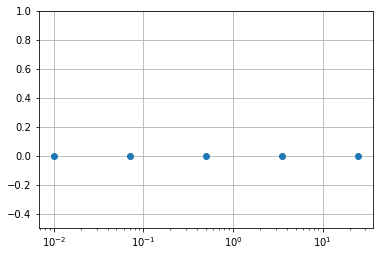

In [26]:
N = 5
x1 = np.logspace(-2, 1.397, N, endpoint=True)## 10**(-1) to 10**(1.397)=25
#x2 = np.logspace(0.1, 1, N, endpoint=False)
y = np.zeros(N)
plt.ylim([-0.5, 1])
plt.grid()
plt.semilogx(x1, y, 'o')
#plt.semilogx(x2, y + 0.5, 'o')

x1[-1]

array([  0.01      ,   0.0143845 ,   0.02069138,   0.02976351,
         0.04281332,   0.06158482,   0.08858668,   0.1274275 ,
         0.18329807,   0.26366509,   0.37926902,   0.54555948,
         0.78475997,   1.12883789,   1.62377674,   2.33572147,
         3.35981829,   4.83293024,   6.95192796,  10.        ])

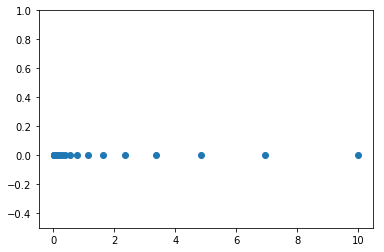

In [18]:
plt.ylim([-0.5, 1])
plt.plot(x1, y, 'o')
#lt.plot(x2, y + 0.5, 'o')
x1

### plotting pictures

In [3]:
x1,x2,x3=np.loadtxt("L12_naive.dat",skiprows=1,unpack=True) 
y1,y2,y3=np.loadtxt("L12_one_body_CD.dat",skiprows=1,unpack=True)

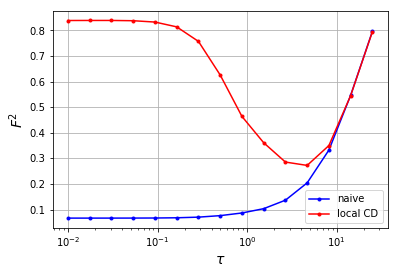

In [6]:
plt.semilogx(x1,x2,'b.-', label="naive")
plt.semilogx(y1,y2,'r.-', label= "local CD")
plt.xlabel(r"$\tau$", fontsize=14)
plt.ylabel(r"$F^2$", fontsize=14)
plt.grid()
plt.legend()
plt.savefig("fidelity_naive.eps")

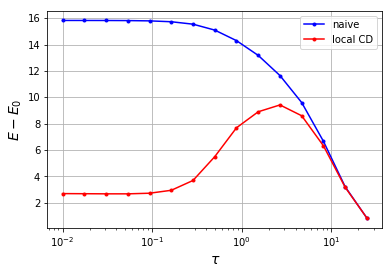

In [8]:
plt.semilogx(x1,x3,'b.-', label="naive")
plt.semilogx(y1,y3,'r.-', label= "local CD")
plt.xlabel(r"$\tau$", fontsize=14)
plt.ylabel(r"$E-E_0$", fontsize=14)
plt.grid()
plt.legend()
plt.savefig("final_energy_naive.eps")

### local CD driving

\begin{equation}
H_0=\sum  \sigma_j^z \sigma_{j+1}^z + \sum  (2  \sigma_j^z +0.8  \sigma_j^x)  + \lambda \sigma_0^x + \dot{\lambda} \alpha_0 \sigma_0^y
\end{equation} 
where $\alpha_0=(6+ (\lambda + 0.8)^2)^{-1}$


In [23]:
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis
import numpy as np # generic math functions
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
import sympy as sp
sp.init_printing(use_unicode=True)#printing option pf sympy

In [27]:
x,tau_0 = sp.symbols('x tau')
def lambda_fn_sym(t,tau):
    pi=np.pi
    #tau=1.0
    lambda_0=0.1
    lambda_f=1.0
    return lambda_0 + (lambda_f-lambda_0)*sp.sin(pi/2*(sp.sin(t*pi/2.0/tau)**2))**2
print lambda_fn_sym(x,tau_0)
def dot_lambda_fn_sym(t,tau):
    return sp.diff(lambda_fn_sym(t, tau),t)
print dot_lambda_fn_sym(x, tau_0)


#lambda_fn_sym_value=(lambda_fn_sym(x).subs({tau:tau_np}))
np_lambda = sp.lambdify((x,tau_0),lambda_fn_sym(x,tau_0), modules=['numpy'])
np_lambda_dot = sp.lambdify((x,tau_0), dot_lambda_fn_sym(x,tau_0), modules=['numpy'])
x_vals = np.linspace(0, 1, 1000)
y_lambda = np_lambda(x_vals,1.0)
y_lambda_dot = np_lambda_dot(x_vals,1.0)

0.9*sin(1.5707963267949*sin(1.5707963267949*x/tau)**2)**2 + 0.1
8.88264396098042*sin(1.5707963267949*x/tau)*sin(1.5707963267949*sin(1.5707963267949*x/tau)**2)*cos(1.5707963267949*x/tau)*cos(1.5707963267949*sin(1.5707963267949*x/tau)**2)/tau


In [ ]:
plt.plot(x_vals,y_lambda,'r', label='prot')
plt.plot(x_vals,y_lambda_dot,'b', label='dot')
plt.xlabel(r"$t/ \tau$")
plt.ylabel(r"$\lambda(t)$")
plt.legend()

In [25]:
def Ham(L):
    basis = spin_basis_1d(L)
    # static 
    J_z = [[1.0,i,(i+1)%L] for i in range(L)] # PBC
    Z = [[2.0,i] for i in range(L)] 
    X = [[0.8,i] for i in range(L)]
    static = [["zz",J_z], ["z",Z], ["x",X]]

    #dynamic var
    def linear_ramp(t):
        global tau
        #print "tau:", tau
        #tau=1
        return t/tau

    def dries_ramp(t):
        global tau
        pi=np.pi
        lambda_0=0.1
        lambda_f=1.0
        return lambda_0 + (lambda_f-lambda_0)*np.sin(pi/2*(np.sin(t*pi/2.0/tau)**2))**2

    
    def alpha_0(t_var):
        return 1.0/(6+ (t_var+0.8)**2 )

    def CD_ramp(t):
        global tau
        p=np.pi
        lambda_0=0.1
        lambda_f=1.0
        return np_lambda_dot(t,tau)*alpha_0(t)

    ramp_args=[]
    s=np.zeros(L)
    s[0]=1
    J_x_t = [[s[j],j] for j in range(L-1) ]
    J_y_t = [[s[j],j] for j in range(L-1) ]

    
    dynamic =[["x", J_x_t,dries_ramp,ramp_args], ["y", J_y_t,CD_ramp,ramp_args]]
    # compute the time-dependent Heisenberg Hamiltonian
    H0 = hamiltonian(static,dynamic,basis=basis,dtype=np.complex_)
    #print J_z,'\n', Z, '\n', X
    #print "Ham \n", H0
    return H0

def fidelity(t,psi):
    energy,evector=H0.eigh(time=t)
    psi_gs=evector[:,0]
    return np.abs(np.vdot(psi_gs,psi))**2

def energy_diff(t,psi):
    energy_psi= np.vdot(psi, H0(time=t).dot(psi))
    gs_energy=H0.eigvalsh(time=t)
    return energy_psi-gs_energy[0] 



L=2
tau=0.01
H0=Ham(L)
E0,V0=H0.eigh(time=0)
psi0=V0[:,0]
t_in=np.linspace(0.1,50,10)


for i in range(len(t_in)):
    tau=t_in[i]
    psi = H0.evolve(psi0,0.0,t_in[i])
    print t_in[i],fidelity(t_in[i],psi), np.real(energy_diff(t_in[i],psi))

Hermiticity check passed!
Symmetry checks passed!
0.1 0.979130328814 0.0536545984399
5.64444444444 0.996684164649 0.00626351427812
11.1888888889 0.999859010027 0.000265131729916
16.7333333333 0.999996981946 5.68856645966e-06
22.2777777778 0.999999988325 4.21825916419e-08
27.8222222222 0.999999984231 5.41999298775e-08
33.3666666667 0.99999998602 5.53051533458e-08
38.9111111111 0.999999984635 6.22604385825e-08
44.4555555556 0.999999982808 7.00969158274e-08
50.0 0.999999980864 7.81768427771e-08
